<a href="https://colab.research.google.com/github/ambgeo/Youtube/blob/main/03_WaterDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##Instalação dos pacotes necessários
!pip install xee -q ##https://github.com/google/Xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.6 MB/s eta 0:00:00


In [3]:
##importando os pacotes python
import ee
import geemap
import xarray as xr
import xee
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
##Autenticação do GEE
ee.Authenticate()
ee.Initialize(project="ee-ambgeo", opt_url='https://earthengine-highvolume.googleapis.com')

In [ ]:
# Select the area of intrest
map=geemap.Map(basemap="SATELLITE")
map

In [58]:
# Obtém a geometria da última feição desenhada no mapa interativo (usada como ROI - região de interesse)
roi = map.draw_last_feature.geometry()

# Define o intervalo de tempo da análise
start_time = '2017-01-01'
end_time = '2024-12-31'

# Cria uma coleção de imagens Sentinel-2 SR (superfície), filtrando:
# - apenas bandas que começam com 'B' (ex: B2, B3, B4...)
# - imagens com menos de 5% de nuvens
# - imagens dentro da região de interesse (roi)
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
        .select(['B.*'])\
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))\
        .filterDate(start_time, end_time)\
        .filterBounds(roi)

# Função para aplicar a cada imagem:
# - divide os valores digitais por 10000 (escala do Sentinel-2 SR)
# - copia a propriedade 'system:time_start'
# - adiciona uma propriedade 'year' com o ano da imagem
def add_year(img):
    date = ee.Date(img.get('system:time_start'))
    year = date.get('year')
    return img.divide(10000).copyProperties(img, ['system:time_start']).set('year', year)

# Aplica a função acima em cada imagem da coleção Sentinel-2
s2_with_year = s2.map(add_year)

# Obtém uma lista ordenada de anos únicos presentes na coleção
years = s2_with_year.aggregate_array('year').distinct().sort()

# Função que calcula a média das imagens de um ano específico
def yearly_mean(year):
    year = ee.Number(year)
    filtered = s2_with_year.filter(ee.Filter.eq('year', year))  # filtra as imagens daquele ano
    mean_image = filtered.mean().set('year', year)  # calcula a média e atribui o ano como propriedade
    return mean_image

# Cria uma coleção de imagens médias anuais, aplicando a função `yearly_mean` para cada ano
yearly_means = ee.ImageCollection(years.map(yearly_mean))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

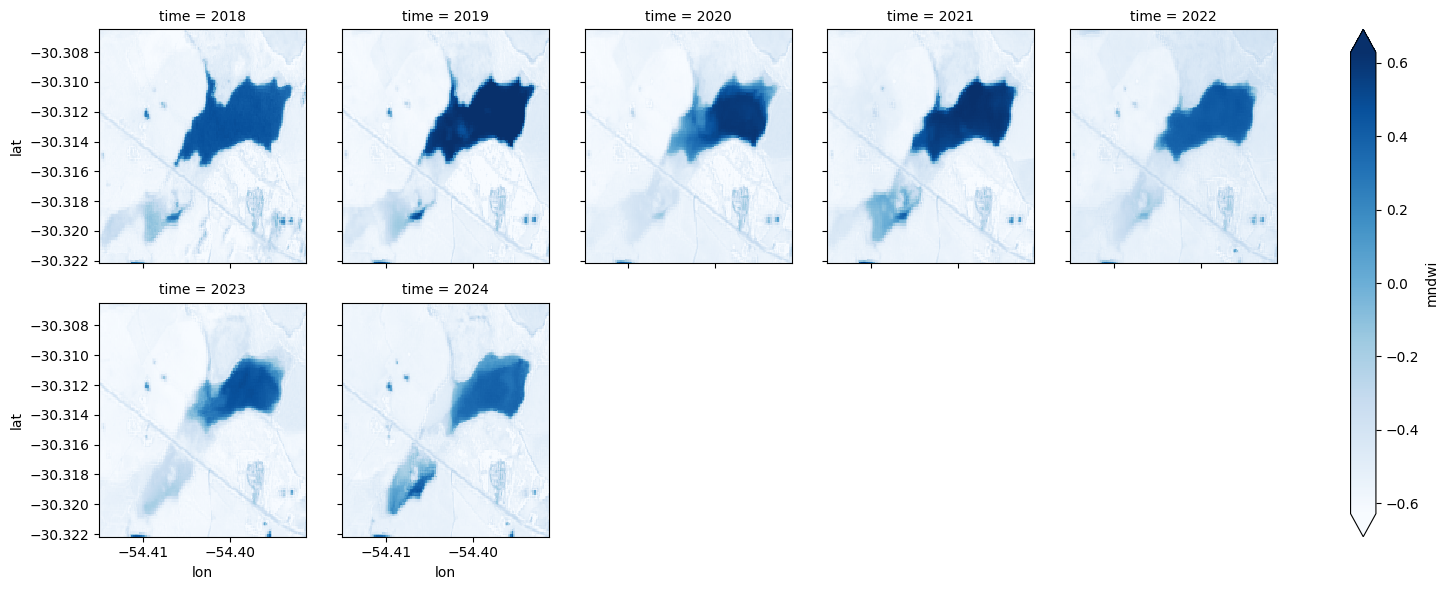

In [60]:
# Função para calcular o índice MNDWI (Modified NDWI) com as bandas B3 (verde) e B11 (SWIR)
# Renomeia o índice para 'mndwi' e mantém as propriedades originais da imagem
def ndwi(img):
    index = img.normalizedDifference(['B3','B11']).rename('mndwi')
    return index.copyProperties(img, img.propertyNames())

# Aplica a função NDWI (MNDWI) para cada imagem da coleção de médias anuais
ndwi_yearly = yearly_means.map(ndwi)

# Extrai os anos disponíveis da coleção como lista
years = ndwi_yearly.aggregate_array('year').getInfo()

# Carrega a coleção NDWI anual como um xarray Dataset, usando a engine do Earth Engine
# Define o sistema de coordenadas (EPSG:4326), a resolução (0.0001 graus ≈ 10 metros) e a região de interesse
ds = xr.open_dataset(ndwi_yearly, engine='ee', crs='EPSG:4326', scale=0.0001, geometry=roi)

# Converte os anos em formato datetime e associa como coordenada temporal no Dataset
new_time = pd.to_datetime([str(y) for y in years]).year
ds['time'] = new_time

# Extrai o DataArray do índice MNDWI para visualização
ndwi_annual = ds['mndwi']

# Plota o índice MNDWI ao longo do tempo:
# - um painel por ano (`col='time'`)
# - em tons de azul (`cmap='Blues'`)
# - com layout robusto para evitar distorções
ndwi_annual.plot(
    x='lon',
    y='lat',
    cmap='Blues',
    col='time',
    col_wrap=5,
    robust=True
)

# Salva a figura gerada em alta resolução (360 dpi)
plt.savefig('water.png', dpi=360, bbox_inches='tight')

# Exibe o plot (caso esteja em ambiente interativo como Jupyter)
plt

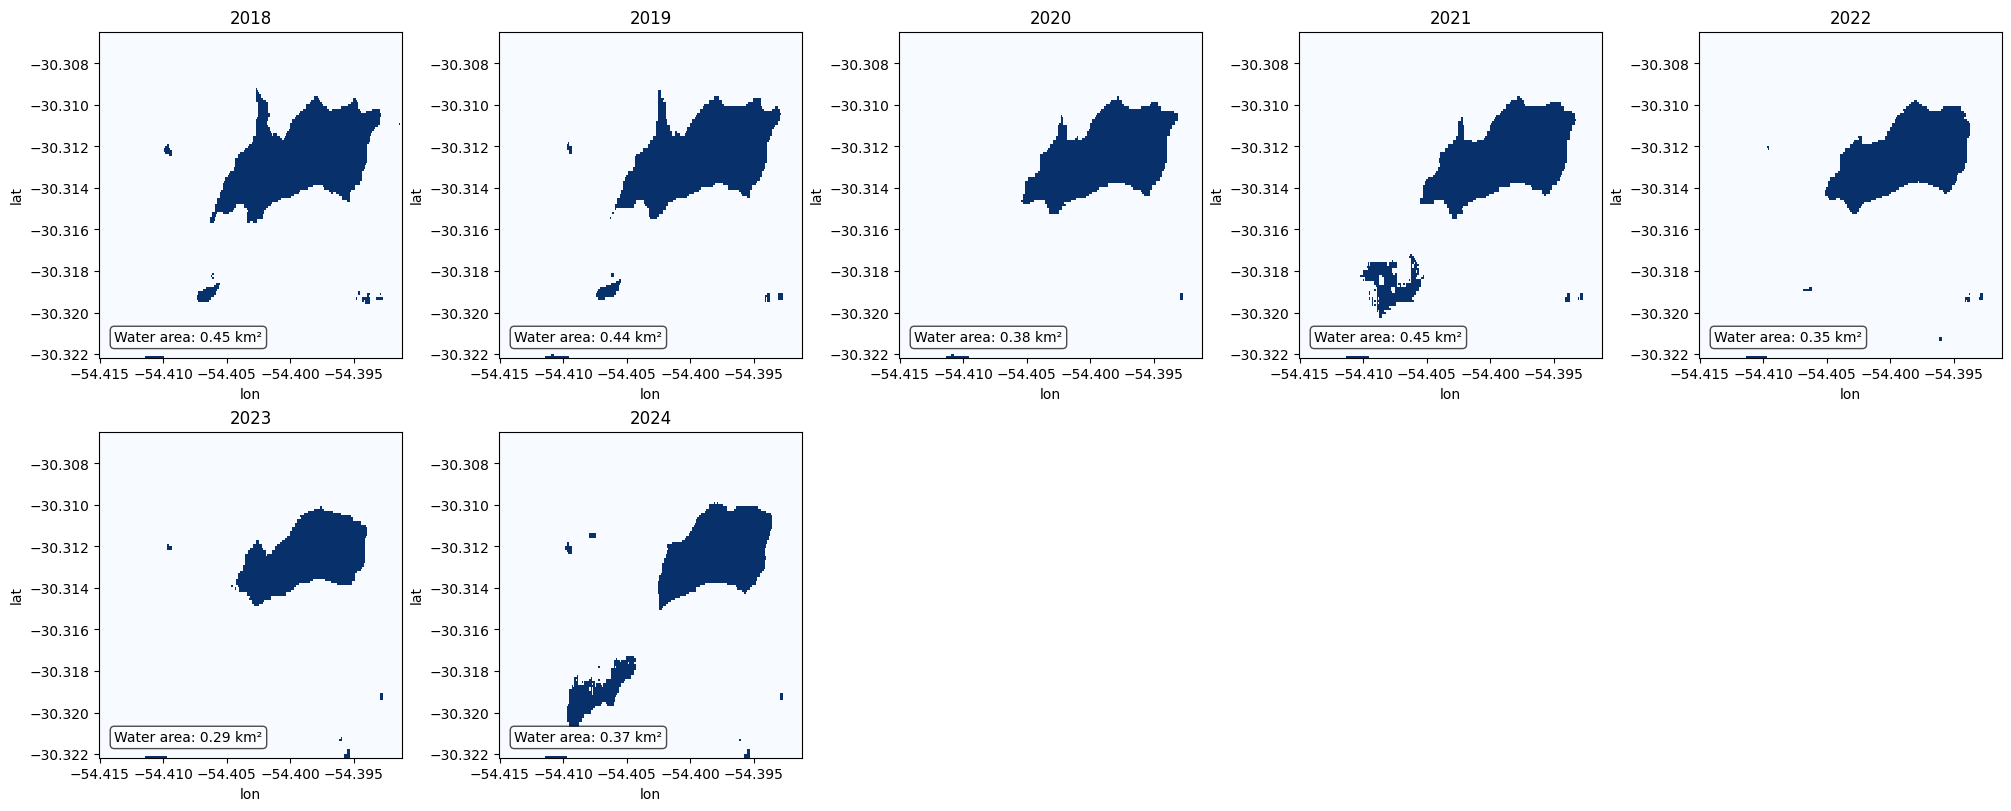

In [61]:
# Converte o xarray Dataset para um DataFrame e reinicia os índices para facilitar manipulação
df = ds.to_dataframe().reset_index()

# Remove linhas onde o índice 'mndwi' está ausente (NaN)
df = df.dropna(subset=['mndwi'])

# Aplica KMeans com 2 clusters (água vs. não-água), baseado nos valores de MNDWI
model = KMeans(n_clusters=2, random_state=42)
df['clustering'] = model.fit_predict(df[['mndwi']])

# Reconstrói o DataArray (xarray) com os resultados da clusterização
xarr = df.set_index(['time', 'lat', 'lon']).to_xarray()

# Organiza as coordenadas para facilitar a visualização (garante ordem crescente)
xarr = xarr.sortby('lon').sortby('lat')

# Calcula o número de pixels classificados como "água" (cluster 1) para cada ano
lake_pixels_per_year = (xarr.clustering == 1).sum(dim=['lat', 'lon'])

# Define a área de um pixel Sentinel-2 em km² (10m x 10m = 100 m² = 0.0001 km²)
pixel_area_km2 = (10 * 10) / 1e6

# Calcula a área total de água para cada ano (número de pixels vezes área por pixel)
lake_area_per_year = lake_pixels_per_year * pixel_area_km2
lake_area_values = lake_area_per_year.values  # extrai os valores como array numpy

# Prepara variáveis auxiliares para organizar os subplots
years = xarr['time'].values
n_years = len(years)
n_cols = 5  # número de colunas por linha no grid de gráficos
n_rows = (n_years + n_cols - 1) // n_cols  # calcula o número mínimo de linhas necessárias

# Cria a figura com subplots organizados em grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()  # transforma a matriz de eixos em uma lista simples para iteração

# Itera sobre os anos e plota o mapa de clusters com a área estimada de água
for i, year in enumerate(years):
    data = xarr.clustering.sel(time=year)  # seleciona o mapa do ano atual
    im = data.plot(
        ax=axes[i],
        x='lon',
        y='lat',
        cmap='Blues',
        add_colorbar=False
    )
    year_str = pd.to_datetime(str(year)).year  # converte o valor do tempo em ano legível
    area = lake_area_values[i]  # área correspondente ao ano
    axes[i].set_title(f"{year_str}")

    # Adiciona um texto no canto inferior esquerdo com a área de água em km²
    axes[i].text(
        0.05, 0.05,
        f"Water area: {area:.2f} km²",
        transform=axes[i].transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )

# Desativa os subplots excedentes (caso o número de anos não preencha o grid)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Salva o conjunto de mapas com a área destacada como imagem PNG
plt.savefig("water_clustering_with_area_labels.png", dpi=360, bbox_inches='tight')

# Exibe o resultado final
plt.show()